In [1]:
from pathlib import Path 
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 

from torchvision.transforms import v2 
from torchvision.io import read_file, decode_image 
import random 
import torchvision.transforms.functional as F 

torch.manual_seed(1)

from helpers import * 
img_bytes = read_file('image.png')
orig_img = decode_image(img_bytes)
print(f"{type(orig_img) = }, {orig_img.dtype = }, {orig_img.shape = }")

type(orig_img) = <class 'torch.Tensor'>, orig_img.dtype = torch.uint8, orig_img.shape = torch.Size([3, 512, 512])


### Cut-Thumbnail

In [2]:
class CutThumbnail(nn.Module):
    def __init__(self, prob=0.5, scale_min=0.2, scale_max=0.4):
        super().__init__()
        self.prob = prob 
        self.scale_min = scale_min 
        self.scale_max = scale_max 

    def forward(self, image):
        img = image.clone()
        if random.random() < self.prob: 
            C, H, W = img.shape 
            scale = random.uniform(self.scale_min, self.scale_max)
            th_h = int(H * scale)
            th_w = int(W * scale)
            thumbnail = F.resize(img, [th_h, th_w])
            max_y = H - th_h 
            max_x = W - th_w 
            rand_y = random.randint(0, max_y)
            rand_x = random.randint(0, max_x)
            img[:, rand_y:rand_y + th_h, rand_x:rand_x + th_w] = thumbnail 

        return img 

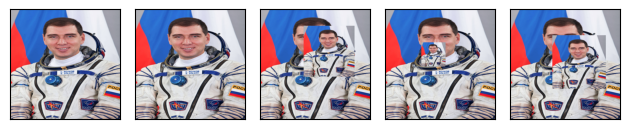

In [3]:
CT_aug = CutThumbnail(prob=0.5, scale_min=0.2, scale_max=0.5)
ct_images = [CT_aug(orig_img) for _ in range(4)]
plot([orig_img] + ct_images)

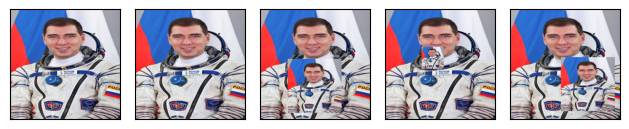

In [4]:
CT_aug = CutThumbnail(prob=0.5, scale_min=0.2, scale_max=0.5)
ct_images = [CT_aug(orig_img) for _ in range(4)]
plot([orig_img] + ct_images)

### YOCO

In [5]:
class YOCO(nn.Module):
    def __init__(self, prob=0.5, trans1=None, trans2=None):
        self.prob = prob 
        self.trans1 = trans1 if trans1 is not None else lambda x: x 
        self.trans2 = trans2 if trans2 is not None else lambda x: x 

    def forward(self, image: torch.Tensor):
        if random.random() < self.prob:
            C, H, W = image.shape 

            if random.random() > 0.5: 
                mid = int(W/2)
                left = image[:, :, :mid]
                right = image[:, :, mid:]

                left_aug = self.trans1(left)
                right_aug = self.trans2(right)

                image = torch.cat([left_aug, right_aug], dim=2)

            else: 
                mid = int(H/2)
                top = image[:, :mid, :]
                bottom = image[:, mid:, :]

                top_aug = self.trans1(top)
                bottom_aug = self.trans2(bottom)

                image = torch.cat([top_aug, bottom_aug], dim=1)
        return image

In [8]:
class YOCO(nn.Module):
    def __init__(self, prob=0.5):
        super().__init__()
        self.prob = prob 

    def random_color_jitter(self):
        brightness = random.uniform(0.6, 1.4)
        contrast = random.uniform(0.6, 1.4)
        saturation = random.uniform(0.6, 1.4)
        hue = random.uniform(0, 0.1)
        return v2.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
    
    def forward(self, image):
        img = image.clone()
        if random.random() < self.prob:
            C, H, W = img.shape 
            if random.random() > 0.5: 
                mid = int(W / 2)
                left = img[:, :, :mid]
                right = img[:, :, mid:]

                left_aug = self.random_color_jitter()(left)
                right_aug = self.random_color_jitter()(right)
                img = torch.cat([left_aug, right_aug], dim=2)

            else: 
                mid = int(H / 2)
                top = img[:, :mid, :]
                bottom = img[:, mid:, :]
                top_aug = self.random_color_jitter()(top)
                bottom_aug = self.random_color_jitter()(bottom)
                img = torch.cat([top_aug, bottom_aug], dim=1)
        return img 

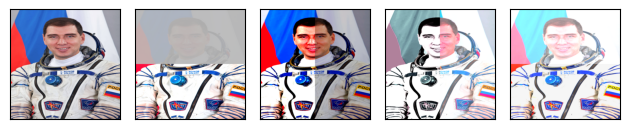

In [9]:
yoco_aug = YOCO(prob=1.0)
yoco_images = [yoco_aug(orig_img) for _ in range(4)]
plot([orig_img] + yoco_images)

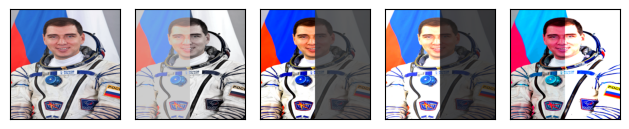

In [10]:
yoco_aug = YOCO(prob=1.0)
yoco_images = [yoco_aug(orig_img) for _ in range(4)]
plot([orig_img] + yoco_images)

### Mixup

In [14]:
!gdown 1Y-Y4jRs6vze_NXjhDiiZ5ofwOhVJW53N
!gdown 1bfdYxy0CaXN4hFnK0xohtvQ4Ivp9B-B2

Downloading...
From: https://drive.google.com/uc?id=1Y-Y4jRs6vze_NXjhDiiZ5ofwOhVJW53N
To: d:\Data Augmentation\src\cat.png

  0%|          | 0.00/1.03M [00:00<?, ?B/s]
 51%|█████     | 524k/1.03M [00:00<00:00, 1.29MB/s]
100%|██████████| 1.03M/1.03M [00:00<00:00, 1.90MB/s]
100%|██████████| 1.03M/1.03M [00:00<00:00, 1.77MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bfdYxy0CaXN4hFnK0xohtvQ4Ivp9B-B2
To: d:\Data Augmentation\src\dog.png

  0%|          | 0.00/1.62M [00:00<?, ?B/s]
 32%|███▏      | 524k/1.62M [00:00<00:00, 1.17MB/s]
 65%|██████▍   | 1.05M/1.62M [00:00<00:00, 2.05MB/s]
 97%|█████████▋| 1.57M/1.62M [00:00<00:00, 2.83MB/s]
100%|██████████| 1.62M/1.62M [00:00<00:00, 2.37MB/s]


In [16]:
imgA = decode_image(read_file('cat.png'))
imgB = decode_image(read_file('dog.png'))

In [17]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1 
    batch_size = x.size()[0]
    if use_cuda: 
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    print(index, lam)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

tensor([1, 0]) 0.8568071091818915


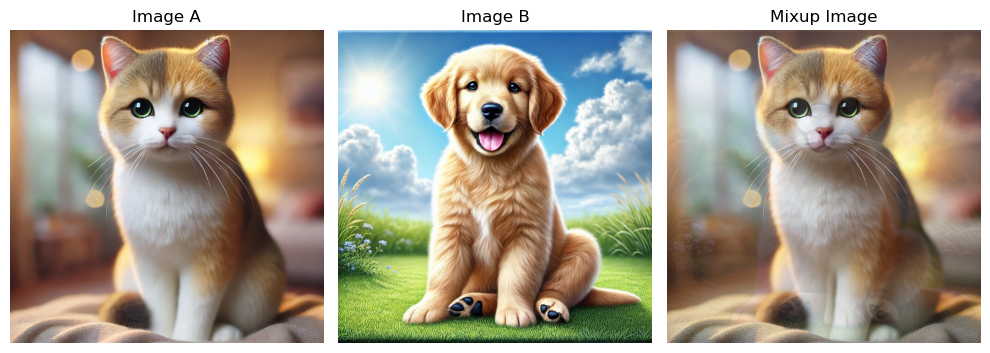

In [19]:

x = torch.concat([torch.unsqueeze(imgA.float(), 0), torch.unsqueeze(imgB.float(), 0)], 0)
y = torch.concat([torch.tensor([0]), torch.tensor([1])])
mixed_img, _, _, _ = mixup_data(x, y, alpha=1.0, use_cuda=False)
mixed_img = mixed_img.squeeze(0).to(torch.uint8)


fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(imgA.permute(1, 2, 0))
axes[0].set_title("Image A")
axes[0].axis("off")


axes[1].imshow(imgB.permute(1, 2, 0))
axes[1].set_title("Image B")
axes[1].axis("off")


axes[2].imshow(mixed_img[0].permute(1, 2, 0))
axes[2].set_title("Mixup Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()

## CutMix

In [28]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0, use_cuda=True):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0]).cuda() if use_cuda else torch.randperm(x.size()[0])
    print(rand_index, lam)
    target_a = y
    target_b = y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, target_a, target_b, lam

tensor([1, 0]) 0.5591527708776947


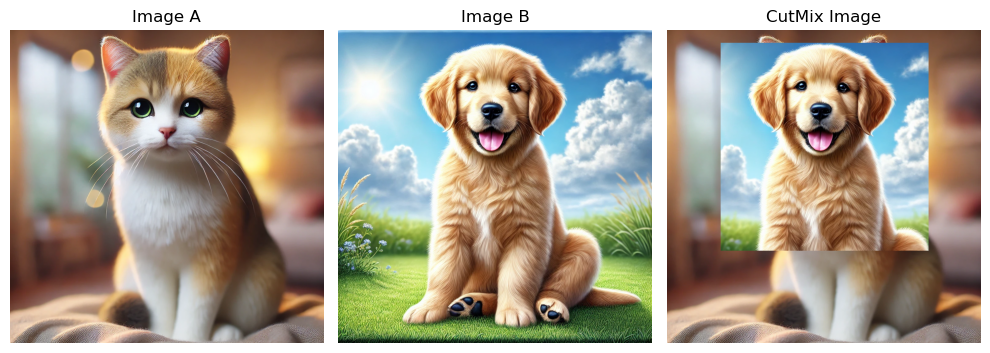

In [34]:

x = torch.concat([torch.unsqueeze(imgA.float(), 0), torch.unsqueeze(imgB.float(), 0)], 0)
y = torch.concat([torch.tensor([0]), torch.tensor([1])])
cutmixed_img, _, _, _ = cutmix_data(x, y, alpha=1.0, use_cuda=False)
cutmixed_img = cutmixed_img.squeeze(0).to(torch.uint8)


fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(imgA.permute(1, 2, 0))
axes[0].set_title("Image A")
axes[0].axis("off")


axes[1].imshow(imgB.permute(1, 2, 0))
axes[1].set_title("Image B")
axes[1].axis("off")


axes[2].imshow(cutmixed_img[0].permute(1, 2, 0))
axes[2].set_title("CutMix Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()